In [5]:
# 0) Imports
import math, time, requests, io, os, json, warnings
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt


In [6]:
warnings.filterwarnings("ignore")
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

In [7]:


# ---------------------------------------------------------
# 1) LOAD DATA from Binance public API (no auth)
# ---------------------------------------------------------
BINANCE = "https://api.binance.com/api/v3/klines"

def fetch_klines(symbol="BTCUSDT", interval="1h", start=None, end=None, limit=1000, sleep=0.2):
    """
    Fetch klines in chunks. start/end: python datetime (UTC). 
    """
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    if start is None:
        # default: 90 days back
        start = datetime.now(timezone.utc) - timedelta(days=90)
    if end is None:
        end = datetime.now(timezone.utc)
    start_ms = int(start.timestamp() * 1000)
    end_ms   = int(end.timestamp() * 1000)

    out = []
    cur = start_ms
    while True:
        p = {**params, "startTime": cur, "endTime": end_ms}
        r = requests.get(BINANCE, params=p, timeout=30)
        r.raise_for_status()
        batch = r.json()
        if not batch:
            break
        out.extend(batch)
        # next window begins at last candle open time + interval
        next_open = batch[-1][0] + 1
        if next_open >= end_ms:
            break
        cur = next_open
        time.sleep(sleep)
    # columns per docs
    cols = [
        "open_time","open","high","low","close","volume",
        "close_time","quote_vol","num_trades","taker_base","taker_quote","ignore"
    ]
    df = pd.DataFrame(out, columns=cols)
    for c in ["open","high","low","close","volume","quote_vol","taker_base","taker_quote"]:
        df[c] = df[c].astype(float)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms", utc=True)
    df = df.set_index("close_time").sort_index()
    return df

df = fetch_klines(symbol="BTCUSDT", interval="1h")
print(df.head())
print("Rows:", len(df))

# (Optional) 1.1 Big-Data hygiene: save to Parquet (cực nhanh & gọn)
os.makedirs("data", exist_ok=True)
df.to_parquet("data/binance_btcusdt_1h.parquet")

                                                 open_time       open       high        low      close     volume  \
close_time                                                                                                          
2025-08-16 16:59:59.999000+00:00 2025-08-16 16:00:00+00:00  117676.70  117817.65  117676.70  117747.65  389.81984   
2025-08-16 17:59:59.999000+00:00 2025-08-16 17:00:00+00:00  117747.64  117747.65  117651.72  117693.00  181.46105   
2025-08-16 18:59:59.999000+00:00 2025-08-16 18:00:00+00:00  117692.99  117757.06  117629.94  117685.79  112.36973   
2025-08-16 19:59:59.999000+00:00 2025-08-16 19:00:00+00:00  117685.78  117771.40  117652.92  117672.12  133.77621   
2025-08-16 20:59:59.999000+00:00 2025-08-16 20:00:00+00:00  117672.13  117713.51  117522.01  117655.41  155.93762   

                                     quote_vol  num_trades  taker_base   taker_quote ignore  
close_time                                                                            

In [12]:
## ---------------------------------------------------------
## EDA 
# ---------------------------------------------------------
# Basic stats
print(df.describe().T)

              count          mean           std           min           25%           50%           75%           max
open         2135.0  1.120189e+05  5.209757e+03  9.524395e+04  1.093860e+05  1.118000e+05  1.152030e+05  1.260112e+05
high         2135.0  1.123090e+05  5.190118e+03  9.569583e+04  1.095907e+05  1.121129e+05  1.154453e+05  1.261996e+05
low          2135.0  1.116945e+05  5.264346e+03  9.456048e+04  1.090940e+05  1.115159e+05  1.149282e+05  1.252527e+05
close        2135.0  1.120090e+05  5.218761e+03  9.524395e+04  1.093827e+05  1.117932e+05  1.151971e+05  1.260112e+05
volume       2135.0  7.883327e+02  8.768506e+02  6.018528e+01  3.492660e+02  5.597115e+02  9.238820e+02  2.293263e+04
quote_vol    2135.0  8.755526e+07  9.617150e+07  6.583966e+06  3.921834e+07  6.320515e+07  1.026856e+08  2.527603e+09
num_trades   2135.0  1.526925e+05  1.418276e+05  1.360800e+04  6.997400e+04  1.150170e+05  1.929420e+05  3.520247e+06
taker_base   2135.0  3.777713e+02  4.221950e+02  1.98466

In [15]:
! pip install prettytable

In [19]:
## prettytable to display some first and last rows
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Index", "Open Time", "Open", "High", "Low", "Close", "Volume"]
for i, row in enumerate(df.itertuples()):
    if i < 3 or i >= len(df) - 3:
        table.add_row([i, row.Index, row.open, row.high, row.low, row.close, row.volume])
print(table)

+-------+----------------------------------+-----------+-----------+-----------+-----------+------------+
| Index |            Open Time             |    Open   |    High   |    Low    |   Close   |   Volume   |
+-------+----------------------------------+-----------+-----------+-----------+-----------+------------+
|   0   | 2025-08-17 17:59:59.999000+00:00 | 117834.55 | 117934.82 | 117645.04 |  117900.0 | 212.98829  |
|   1   | 2025-08-17 18:59:59.999000+00:00 | 117900.01 | 117947.98 | 117321.53 | 117542.01 | 360.32583  |
|   2   | 2025-08-17 19:59:59.999000+00:00 | 117542.01 | 117749.12 |  117468.0 | 117570.07 |  264.4763  |
|  2132 | 2025-11-14 13:59:59.999000+00:00 |  95350.76 |  95695.83 |  94571.1  |  95243.95 | 3578.96625 |
|  2133 | 2025-11-14 14:59:59.999000+00:00 |  95243.95 |  96801.53 |  94951.43 |  96542.38 | 3587.32924 |
|  2134 | 2025-11-14 15:59:59.999000+00:00 |  96542.38 |  96719.74 |  95868.4  |  96711.29 | 1001.70327 |
+-------+----------------------------------+--

In [8]:

# ---------------------------------------------------------
# 2) PREPROCESS & FEATURES (no leakage!)
# ---------------------------------------------------------
# Target: nhị phân 1 nếu close_{t+1} > close_{t}, ngược lại 0
df["ret_1"] = df["close"].pct_change(1)
df["target"] = (df["ret_1"].shift(-1) > 0).astype(int)  # shift(-1) để dự báo tương lai

# Feature set: rolling stats & momentum, tất cả dùng dữ liệu đến thời điểm t (không nhìn tương lai)
def add_features(x, windows=(3,6,12,24)):
    for w in windows:
        x[f"ret_{w}"] = x["close"].pct_change(w)
        x[f"sma_{w}"] = x["close"].rolling(w).mean()
        x[f"ema_{w}"] = x["close"].ewm(span=w, adjust=False).mean()
        x[f"vol_{w}"] = x["ret_1"].rolling(w).std()
        x[f"max_{w}"] = x["high"].rolling(w).max()
        x[f"min_{w}"] = x["low"].rolling(w).min()
        # Simple RSI-like oscillator (không cần lib)
        up = np.clip(x["ret_1"], 0, None)
        down = np.clip(-x["ret_1"], 0, None)
        rs = up.rolling(w).mean() / (down.rolling(w).mean() + 1e-9)
        x[f"rsi_{w}"] = 100 - 100/(1+rs)
    return x

df = add_features(df.copy())

# Tạo lag để tránh leakage (model chỉ nhìn tới t)
feature_cols = [c for c in df.columns if any(k in c for k in ["ret_","sma_","ema_","vol_","max_","min_","rsi_"])]
for c in feature_cols:
    df[c] = df[c].shift(1)   # lag-1 everything

df = df.dropna().copy()

X = df[feature_cols].values
y = df["target"].values


In [9]:


# ---------------------------------------------------------
# 3) TRAIN with TimeSeriesSplit (+ scaling to help convergence)
# ---------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
all_preds = np.zeros_like(y, dtype=float)
all_proba = np.zeros_like(y, dtype=float)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xte = scaler.transform(Xte)

    # LogisticRegression with strong regularization to avoid divergence
    clf = LogisticRegression(max_iter=2000, C=0.5, n_jobs=None)
    clf.fit(Xtr, ytr)

    proba = clf.predict_proba(Xte)[:,1]
    pred  = (proba >= 0.5).astype(int)

    all_preds[test_idx] = pred
    all_proba[test_idx] = proba

print("AUC:", roc_auc_score(y, all_proba))
print(classification_report(y, all_preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(y, all_preds))


AUC: 0.5160237847021121
              precision    recall  f1-score   support

           0      0.512     0.643     0.570      1068
           1      0.519     0.385     0.442      1067

    accuracy                          0.514      2135
   macro avg      0.515     0.514     0.506      2135
weighted avg      0.515     0.514     0.506      2135

Confusion matrix:
 [[687 381]
 [656 411]]


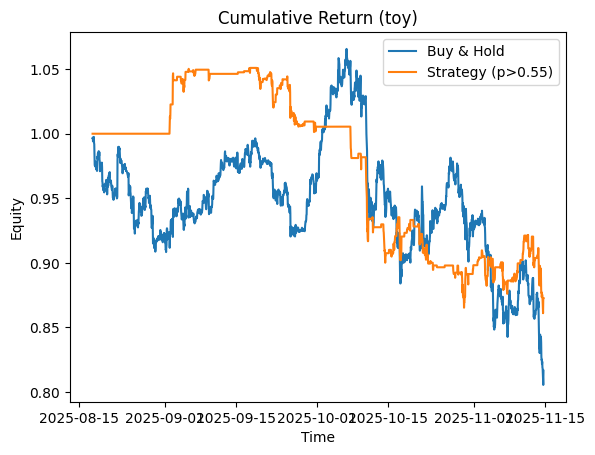

In [10]:

# ---------------------------------------------------------
# 4) SIMPLE DECISION RULE & “BACKTEST” TOY
# ---------------------------------------------------------
# Luật: nếu P(up) > 0.55 thì long 1 “đơn vị” trong giờ tiếp theo, ngược lại đứng ngoài (0).
threshold = 0.55
signal = (all_proba > threshold).astype(int)  # 1=long, 0=flat

# Lợi nhuận thực tế của chiến lược = signal_t * ret_{t+1}
future_ret = df["ret_1"].shift(-1).fillna(0).values
strategy_ret = signal * future_ret

cum_strategy = (1 + strategy_ret).cumprod()
cum_buyhold = (1 + df["ret_1"].fillna(0).values).cumprod()

plt.figure()
plt.plot(df.index, cum_buyhold, label="Buy & Hold")
plt.plot(df.index, cum_strategy, label=f"Strategy (p>{threshold})")
plt.legend(); plt.title("Cumulative Return (toy)")
plt.xlabel("Time"); plt.ylabel("Equity")
plt.show()


In [11]:


# ---------------------------------------------------------
# 5) QUICK REPORT
# ---------------------------------------------------------
report = {
    "rows": int(len(df)),
    "features": len(feature_cols),
    "auc": float(roc_auc_score(y, all_proba)),
    "threshold": threshold,
    "final_equity_strategy": float(cum_strategy[-1]),
    "final_equity_buyhold": float(cum_buyhold[-1]),
}
print(json.dumps(report, indent=2))


{
  "rows": 2135,
  "features": 29,
  "auc": 0.5160237847021121,
  "threshold": 0.55,
  "final_equity_strategy": 0.8727495671765411,
  "final_equity_buyhold": 0.8164525596433759
}
